In [3]:
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

## 1. Getting a dataset

Let's get FashionMNIST dataset. It contains grayscale images of 10 different kinds of clothing.

In [4]:
# Download training data from open datasets.
train_dataset = datasets.MNIST(
    root="/home/gopalakrishnanm/Projects/Pytorch_tutorial/data/mnist/",
    train=True,
    download=False,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_dataset = datasets.MNIST(
    root="/home/gopalakrishnanm/Projects/Pytorch_tutorial/data/mnist/",
    train=False,
    download=False,
    transform=ToTensor(),
)
#mnist_dataset = datasets.MNIST(root='/home/gopalakrishnanm/Projects/Pytorch_tutorial/mnist/', train=True, download=False)

In [13]:
# See first training sample
image, label = train_dataset[0]
print("Shape of image [N, C, H, W]::",image.shape)
print("Label:", label)

Shape of image [N, C, H, W]:: torch.Size([1, 28, 28])
Label: 9


The shape of the image tensor is [1, 28, 28] or more specifically:

`[color_channels=1, height=28, width=28]`

Having color_channels=1 means the image is grayscale.

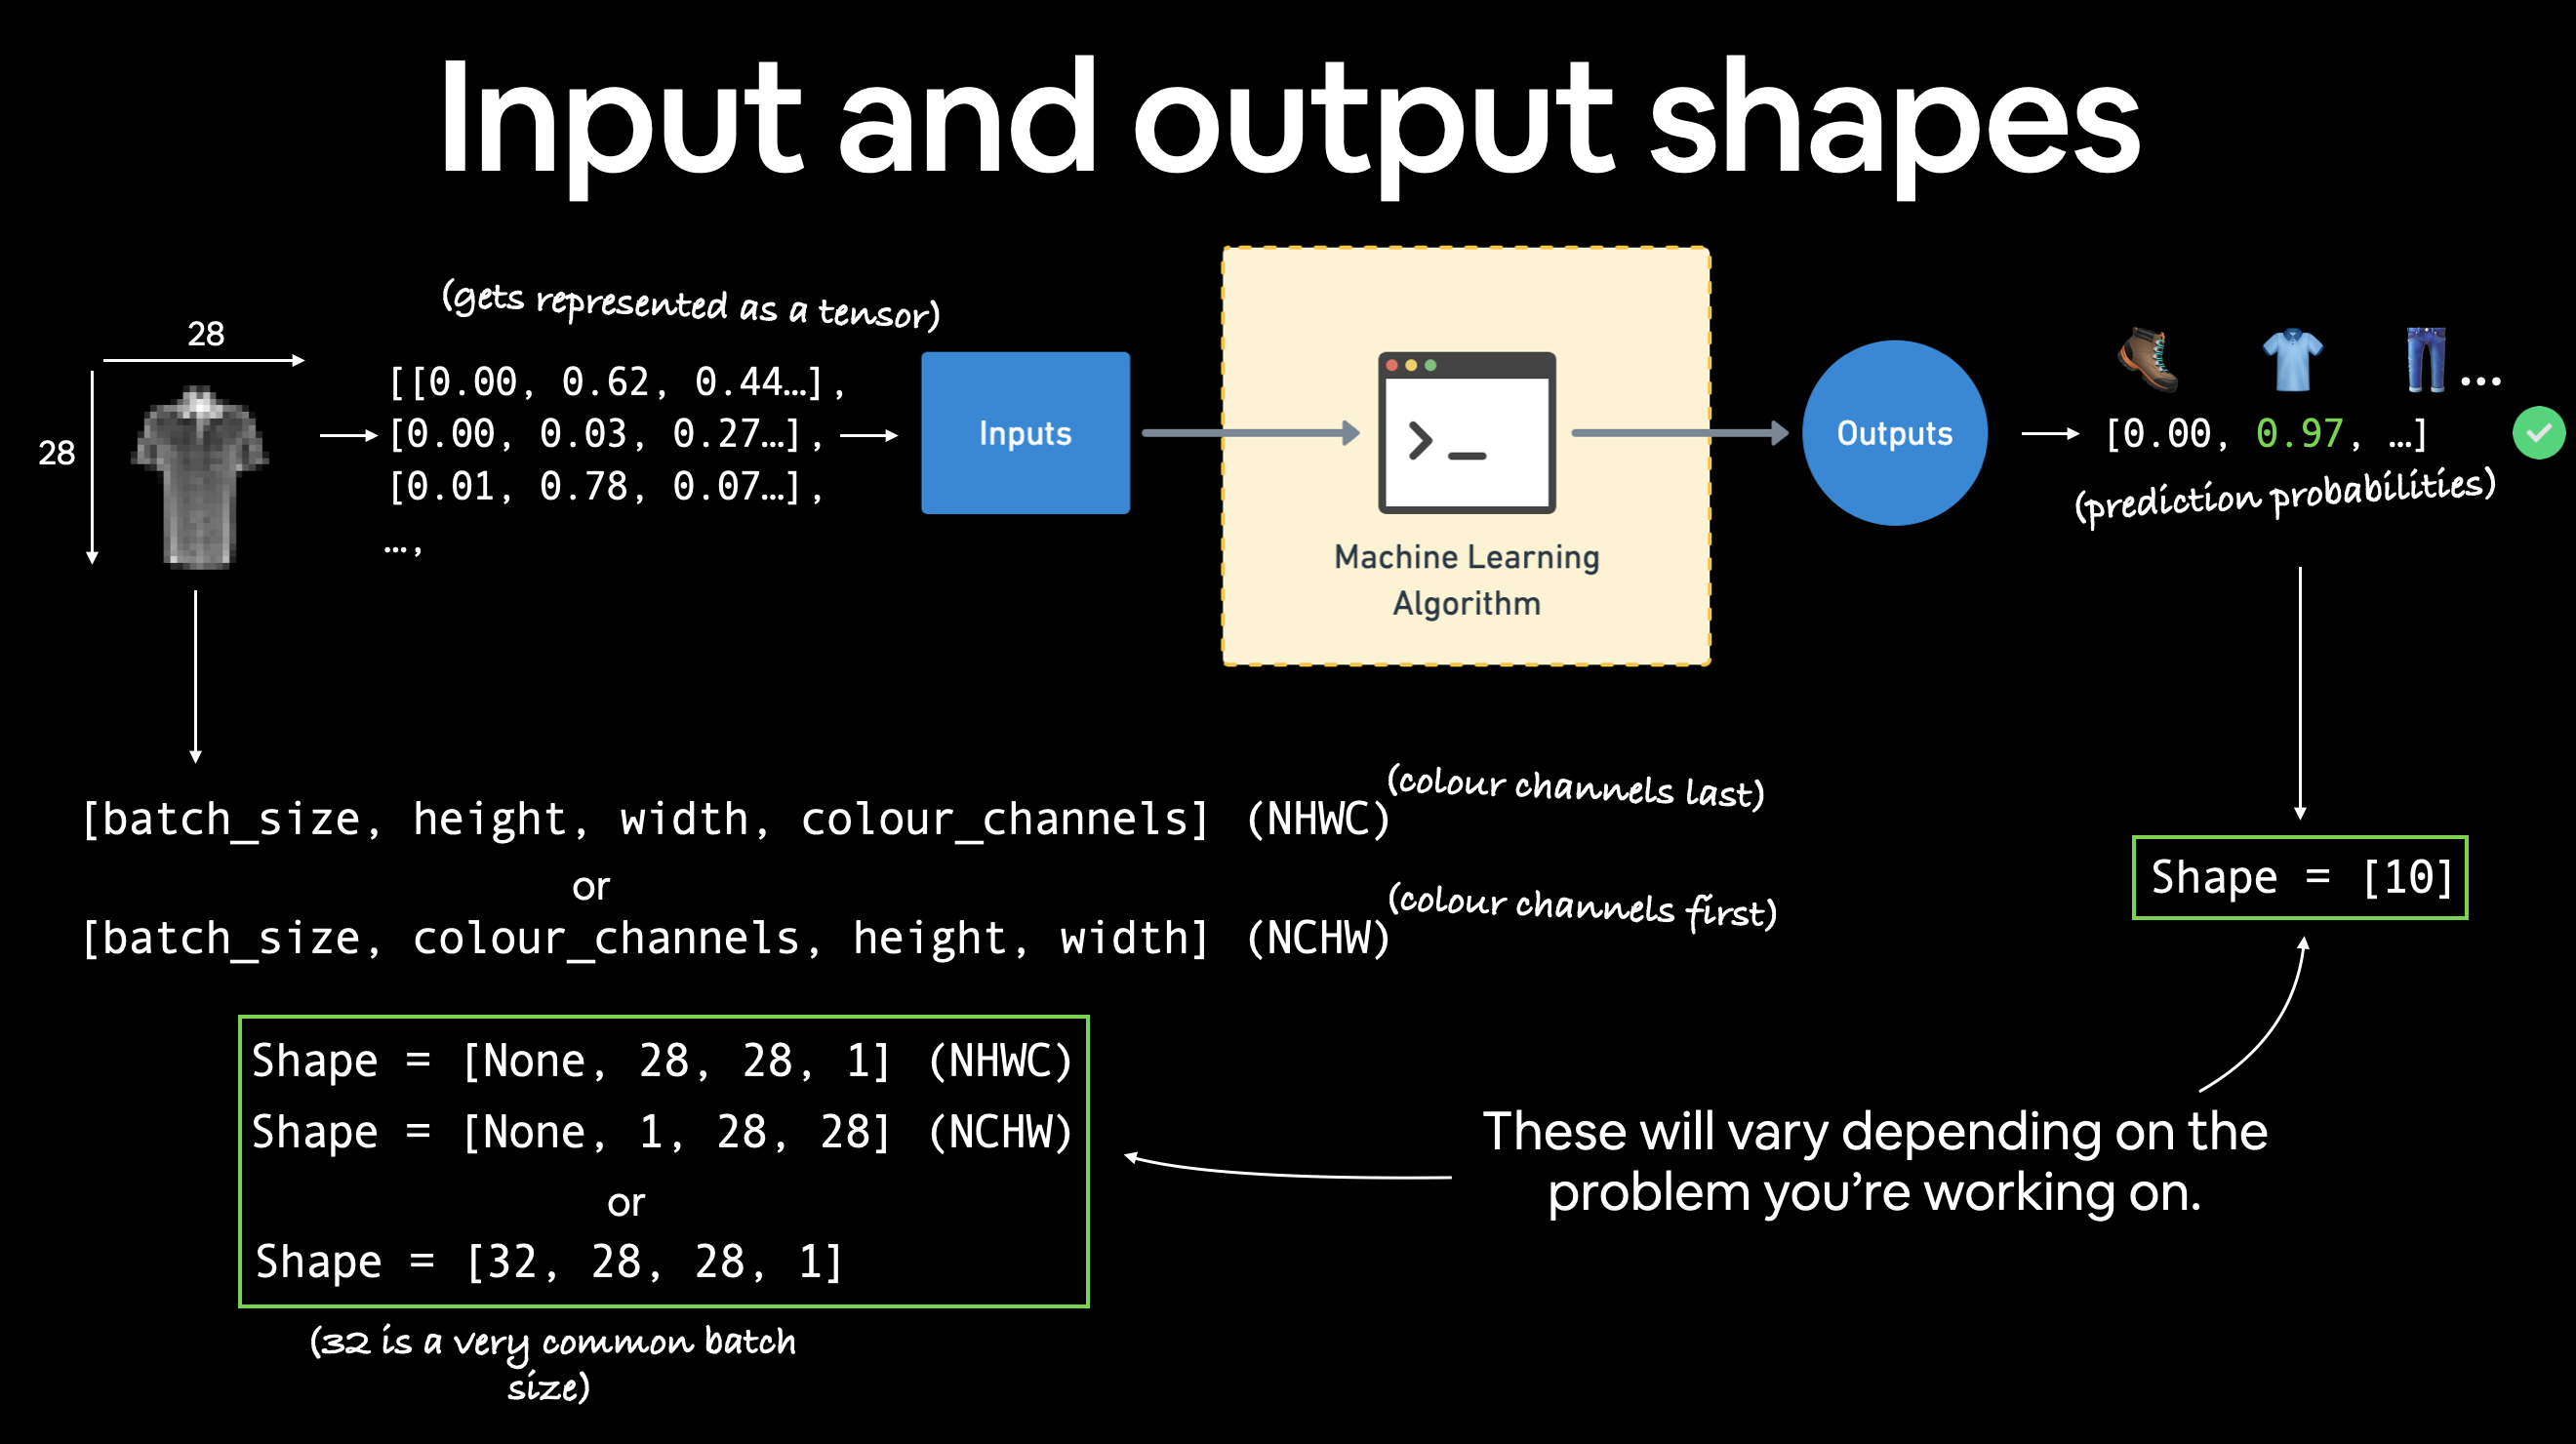


If color_channels=3, the image comes in pixel values for red, green and blue (this is also known as the RGB color model).

The order of our current tensor is often referred to as CHW (Color Channels, Height, Width).

In [7]:
# How many samples are there?
len(train_dataset.data), len(train_dataset.targets), len(test_dataset.data), len(test_dataset.targets)

(60000, 60000, 10000, 10000)

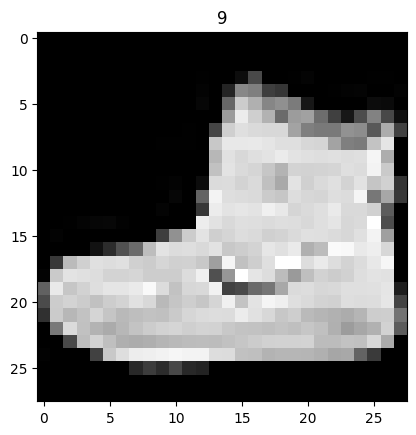

In [8]:
import matplotlib.pyplot as plt
image, label = train_dataset[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(label);

The `DataLoader` helps load data into a model. It turns a large Dataset into a Python iterable of smaller chunks. These smaller chunks are called batches or mini-batches and can be set by the `batch_size` parameter. We do this because it's more computationally efficient. With mini-batches (small portions of the data), gradient descent is performed more often per epoch (once per mini-batch rather than once per epoch).

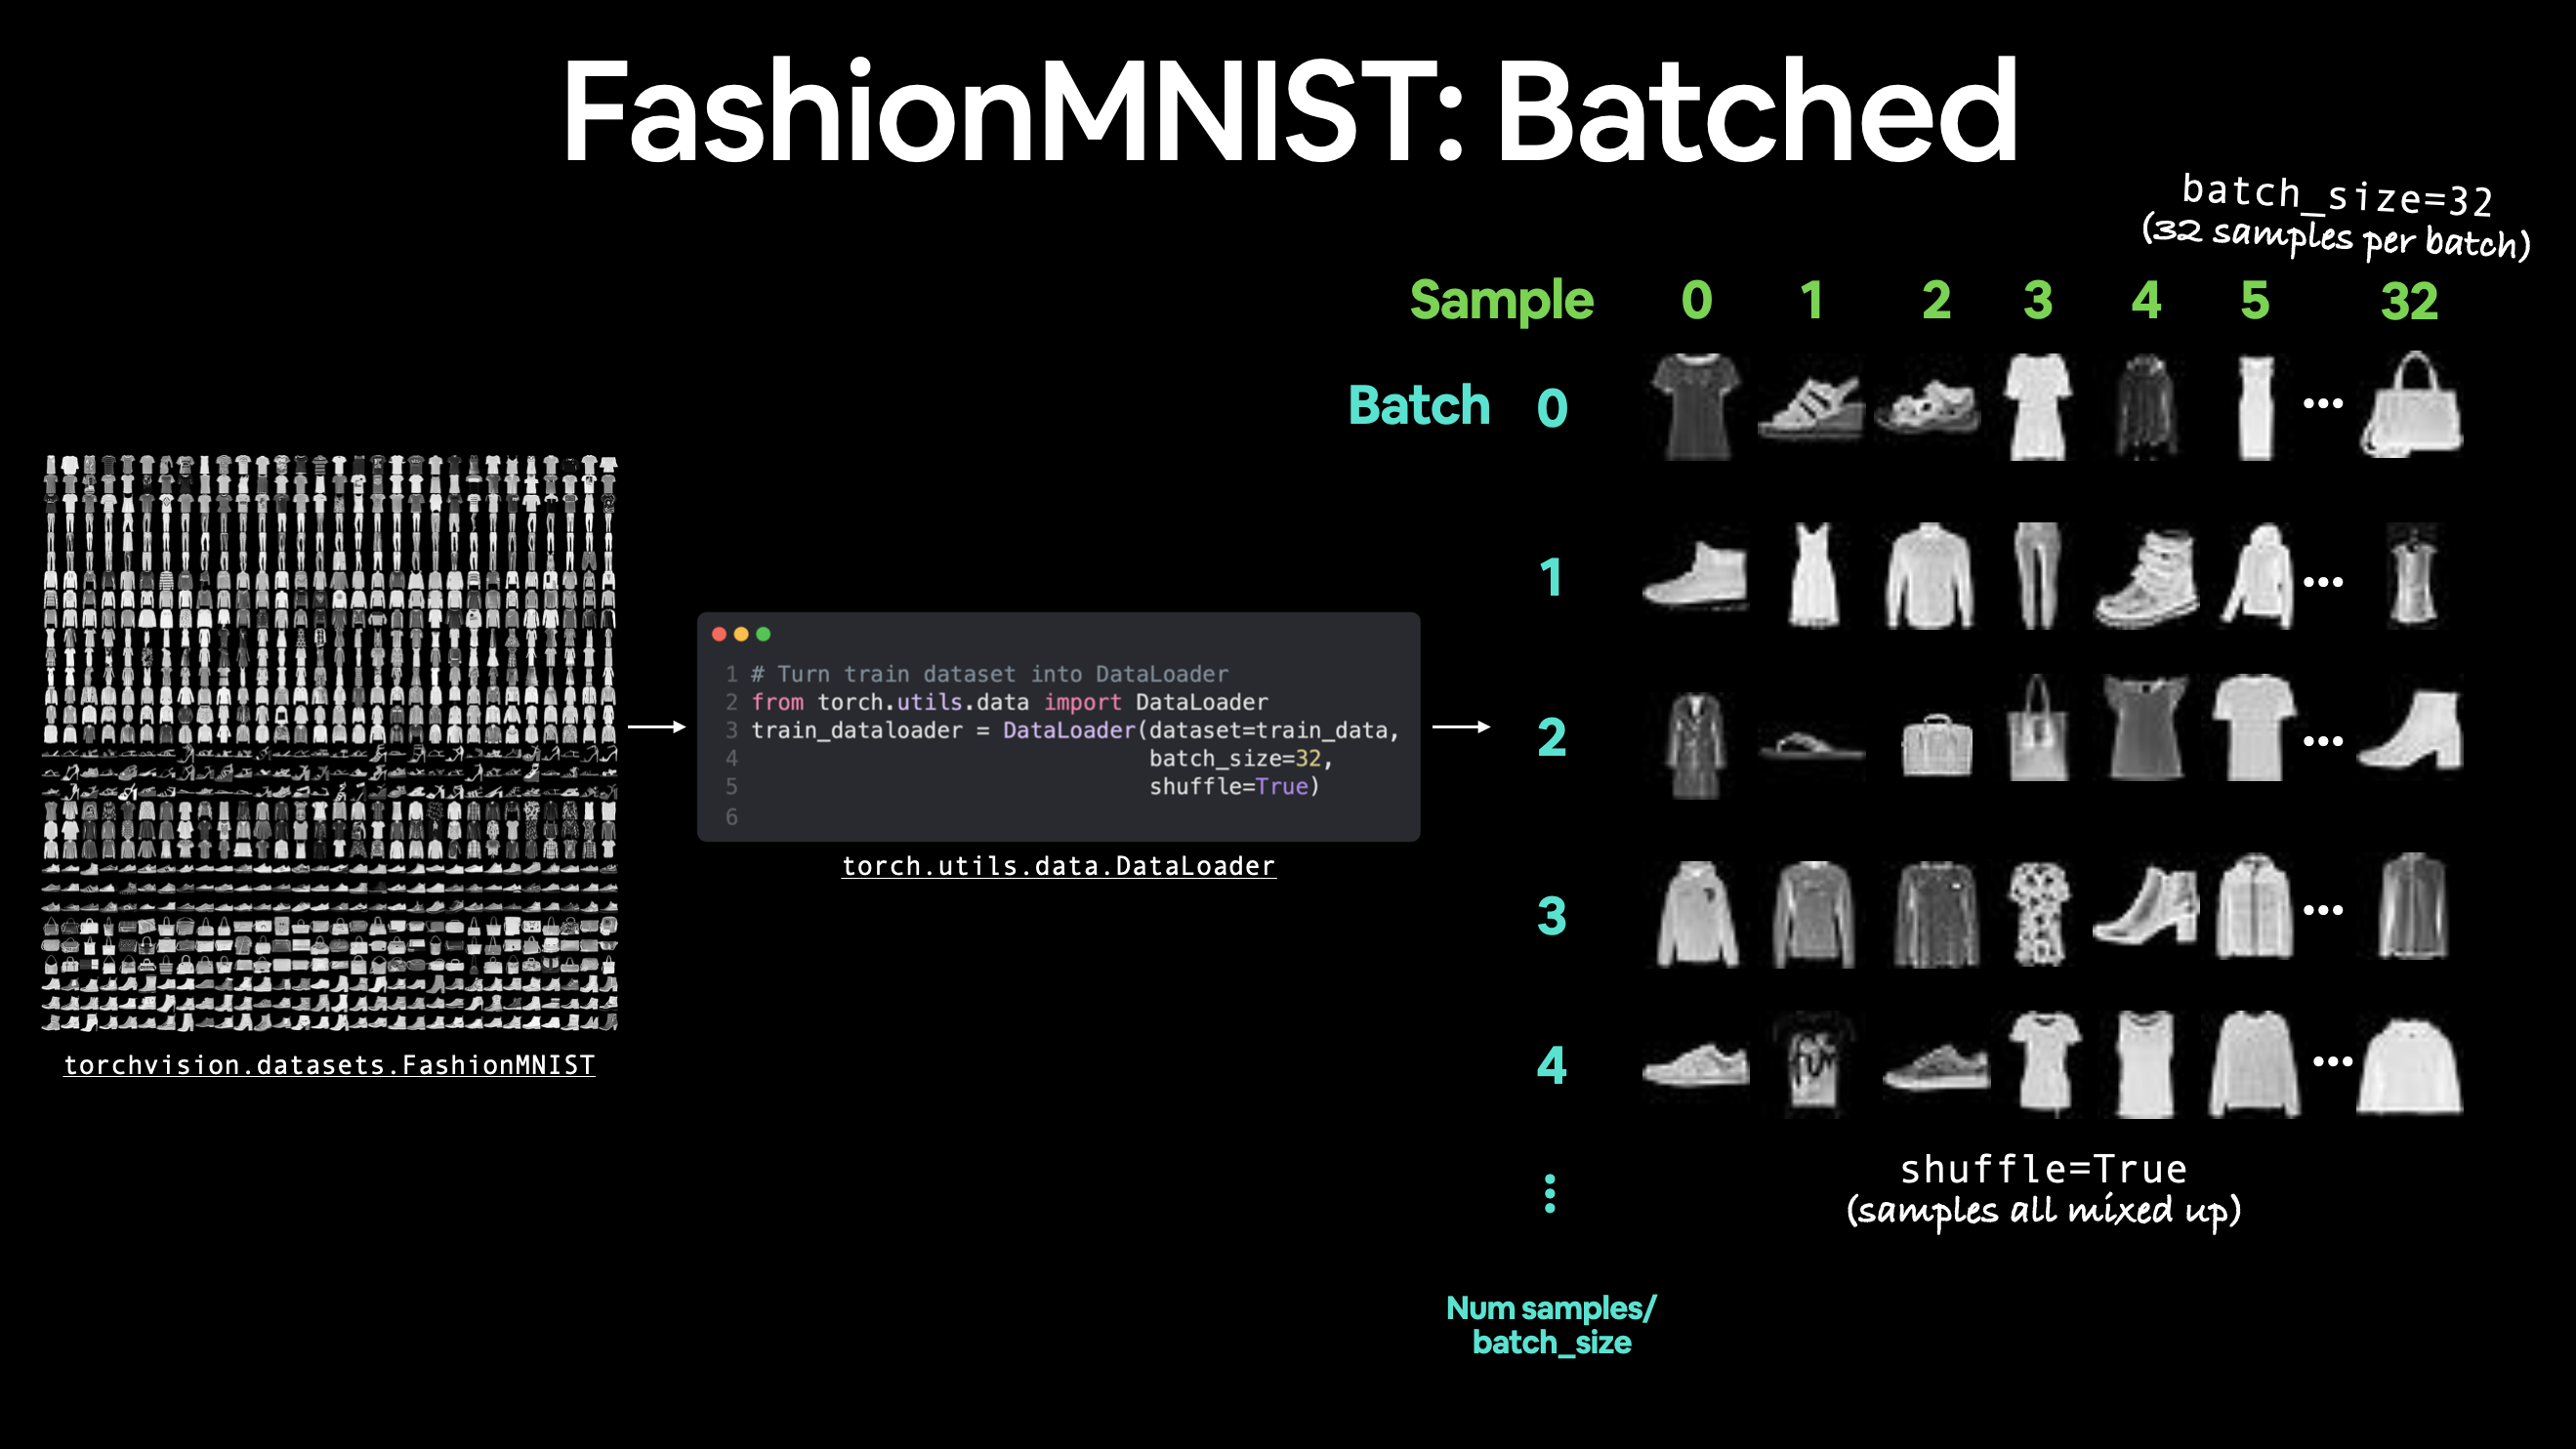

In [21]:
BATCH_SIZE = 32

# Create data loaders.
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
# for X_batch, y_batch in test_dataloader:
#     print(f"Shape of X [N, C, H, W]: {X_batch.shape}")
#     print(f"Shape and datatype ofof y: {y_batch.shape} {y_batch.dtype}")
#     break

# Check out what's inside the training dataloader
X_batch, y_batch = next(iter(train_dataloader))
print(f"Shape of X [N, C, H, W]: {X_batch.shape}")
print(f"Shape and datatype of y: {y_batch.shape} {y_batch.dtype}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f339b3fe4d0>, <torch.utils.data.dataloader.DataLoader object at 0x7f339b3fdc00>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32
Shape of X [N, C, H, W]: torch.Size([32, 1, 28, 28])
Shape and datatype of y: torch.Size([32]) torch.int64


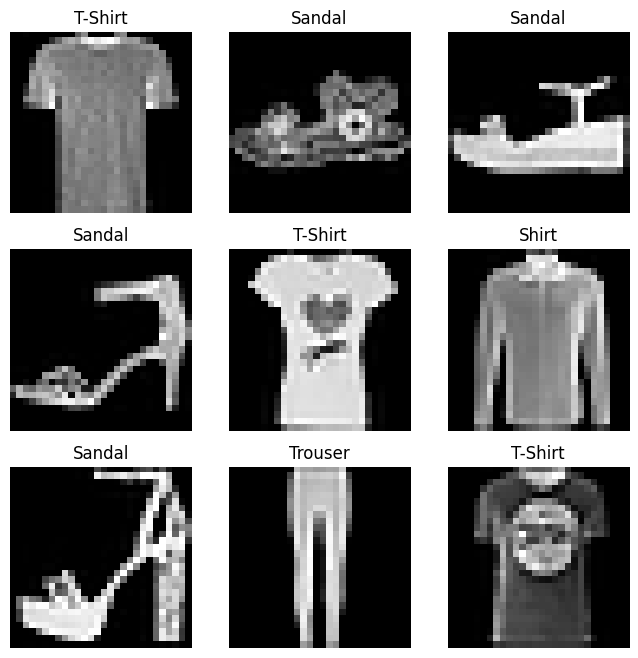

In [25]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [26]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


Label:4
Label Value: Coat


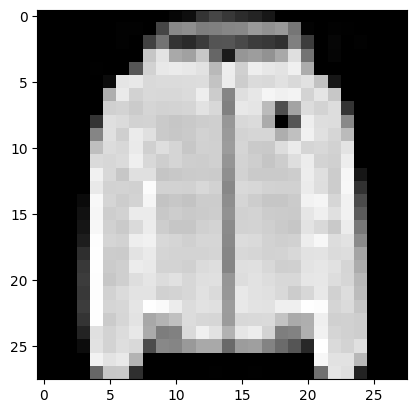

In [27]:
img = X_batch[0].squeeze()
label = y_batch[0].item()
plt.imshow(img, cmap="gray")
print(f"Label:{label}")
print(f"Label Value: {labels_map[label]}")

## Build a baseline model

A baseline model is one of the simplest models and later we can improve upon it.

Our baseline will consist of two `nn.Linear()` layers. Because we're working with image data, we use `nn.Flatten()` to compress the dimensions of a tensor into a single vector.

In [32]:
from torch import nn

class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape:int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self,x):
        out = self.layer_stack(x)
        return out

The `nn.Flatten()` layer took our shape from `[color_channels, height, width]` to `[color_channels, height*width]`.

In [31]:
flatten_layer = nn.Flatten()
output = flatten_layer(X_batch[0])
# Print out what happened
print(f"Shape before flattening: {X_batch[0].shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")


Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


Let's create an instance of our model and send to the CPU for now

In [34]:
torch.manual_seed(42) # To set the seed for PyTorch’s random number generator, ensuring reproducibility in your experiments.

model_v0 = FashionMNISTModelV0(input_shape=28*28,
                               hidden_units=10,
                               output_shape=len(labels_map))

model_v0.to('cpu')

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

## Setup loss, optimizer and evaluation metrics

In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_v0.parameters(), lr=0.1)

In [37]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

## Train the model

In [59]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

torch.manual_seed(42)
train_time_start_cpu = timer()

EPOCHS = 3

for epoch in (range(EPOCHS)):
    pbar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{EPOCHS}', ncols=100, mininterval=0.5)
    for batch, (images, labels) in enumerate(pbar):

        labels_pred = model_v0(images)
        loss = loss_fn(labels_pred, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 400 == 0:
            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        # if batch % 400 == 0:
        #     print("Epoch [{}/{}] Step [{}/{}] Loss:{:.4f}".format(epoch, EPOCHS, batch, len(train_dataloader), loss.item()))


Epoch 3/3: 100%|██████████████████████████████████| 1875/1875 [00:03<00:00, 535.41it/s, Loss=0.5749]


In [73]:
import numpy as np
pbar = tqdm(np.arange(EPOCHS), desc=f'Epoch:', ncols=100)
for epoch in pbar:
    for batch, (images, labels) in enumerate(train_dataloader):
        labels_pred = model_v0(images)
        loss = loss_fn(labels_pred, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

Epoch:: 100%|████████████████████████████████████████████| 3/3 [00:10<00:00,  3.36s/it, Loss=0.3721]


### Get Device for Training
We want to be able to train our model on an accelerator such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

In [8]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Build the Neural Network
Neural networks comprise of layers/modules that perform operations on data. The torch.nn namespace provides all the building blocks you need to build your own neural network. Every module in PyTorch subclasses the nn.Module. A neural network is a module itself that consists of other modules (layers). This nested structure allows for building and managing complex architectures easily.

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(nn.Linear(28*28, 512),
                                               nn.ReLU(),
                                               nn.Linear(512,512),
                                               nn.ReLU(),
                                               nn.Linear(512,10)
                                               )
    def forward(self,x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

#### Create an instance of NeuralNetwork, and move it to the device, and print its structure.

In [10]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Optimizing the Model Parameters
To train a model, we need a loss function and an optimizer.

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [12]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model’s performance against the test dataset to ensure it is learning.

In [13]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model’s accuracy and loss at each epoch; we’d like to see the accuracy increase and the loss decrease with every epoch.

In [14]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.310643  [   64/60000]
loss: 2.296324  [ 6464/60000]
loss: 2.284990  [12864/60000]
loss: 2.269741  [19264/60000]
loss: 2.262004  [25664/60000]
loss: 2.232236  [32064/60000]
loss: 2.230967  [38464/60000]
loss: 2.204039  [44864/60000]
loss: 2.206415  [51264/60000]
loss: 2.174628  [57664/60000]
Test Error: 
 Accuracy: 44.1%, Avg loss: 2.168279 

Epoch 2
-------------------------------
loss: 2.182887  [   64/60000]
loss: 2.168773  [ 6464/60000]
loss: 2.121470  [12864/60000]
loss: 2.125368  [19264/60000]
loss: 2.089832  [25664/60000]
loss: 2.033465  [32064/60000]
loss: 2.047800  [38464/60000]
loss: 1.979905  [44864/60000]
loss: 1.991750  [51264/60000]
loss: 1.918564  [57664/60000]
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.913645 

Epoch 3
-------------------------------
loss: 1.951821  [   64/60000]
loss: 1.917964  [ 6464/60000]
loss: 1.811537  [12864/60000]
loss: 1.837686  [19264/60000]
loss: 1.750377  [25664/60000]
loss: 1.696152  [32064/600

### Saving models
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).

In [19]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


### Loading Models
The process for loading a model includes re-creating the model structure and loading the state dictionary into it.

In [20]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

### Predicting

In [27]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
for i in range(0,20):
    x, y = test_data[i][0], test_data[i][1]
    with torch.no_grad():
        x = x.to(device)
        pred = model(x)
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
Predicted: "Pullover", Actual: "Pullover"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "Shirt", Actual: "Shirt"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "Shirt", Actual: "Coat"
Predicted: "Coat", Actual: "Shirt"
Predicted: "Sneaker", Actual: "Sandal"
Predicted: "Sneaker", Actual: "Sneaker"
Predicted: "Pullover", Actual: "Coat"
Predicted: "Sneaker", Actual: "Sandal"
Predicted: "Sneaker", Actual: "Sneaker"
Predicted: "Dress", Actual: "Dress"
Predicted: "Coat", Actual: "Coat"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "Pullover", Actual: "Pullover"
Predicted: "Pullover", Actual: "Coat"
Predicted: "Bag", Actual: "Bag"
Predicted: "T-shirt/top", Actual: "T-shirt/top"
